In [1]:
import albumentations as A

import torch

from torchvision import models
from torchvision import transforms as T

from pathlib import Path

from PIL import Image

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
model = torch.load('/home/enfycius/Documents/LH_Dataset/Semantic_Segmentation/models_v2/Unet.pt')

In [4]:
model.to(device)

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [5]:
import numpy as np
import cv2

import os

In [6]:
def get_files(path):
    files = []
    files_path = []

    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            files.append(filename)
            files_path.append(dirname + filename)

    return [files, files_path]

In [7]:
def path_to_img(paths, flag=cv2.IMREAD_COLOR):
    imgs = []

    _, paths = get_files(paths)

    for path in paths:
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        imgs.append(img)
        
    return [imgs, paths]

In [8]:
def transform_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    img_transforms = A.Compose([A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)])
    aug = img_transforms(image = img)
    img = Image.fromarray(aug['image'])

    ori = img

    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    
    img = t(img)
    img = img.to(device)

    return [img.unsqueeze(0), ori]

In [9]:
def predict_image(img):
    with torch.no_grad():
        output = model(img)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)

    return masked

In [10]:
TEST_PATH = "/home/enfycius/Documents/LH_Dataset/Semantic_Segmentation/imgs_v2/"

In [11]:
folders = ["ass", "not_ass"]

In [12]:
imgs_l = []
path_l = []

In [13]:
for folder in folders:
    imgs_l.append(path_to_img(TEST_PATH + folder + "/"))
    path_l.append(folder)

In [14]:
imgs_l

[[[array([[[141, 137, 126],
           [143, 139, 128],
           [141, 137, 126],
           ...,
           [174, 170, 159],
           [174, 170, 161],
           [178, 174, 165]],
   
          [[141, 137, 126],
           [140, 136, 125],
           [139, 135, 124],
           ...,
           [171, 167, 156],
           [173, 169, 160],
           [178, 174, 165]],
   
          [[138, 134, 123],
           [138, 134, 123],
           [140, 136, 125],
           ...,
           [166, 162, 151],
           [171, 167, 158],
           [178, 174, 165]],
   
          ...,
   
          [[121, 117, 108],
           [130, 126, 117],
           [123, 119, 110],
           ...,
           [155, 149, 141],
           [149, 145, 136],
           [152, 148, 139]],
   
          [[131, 126, 120],
           [129, 124, 118],
           [124, 119, 113],
           ...,
           [159, 155, 146],
           [150, 145, 139],
           [159, 154, 148]],
   
          [[141, 136, 130],
        

In [15]:
SAVE_PATH = "/home/enfycius/Desktop/prediction_v2/"

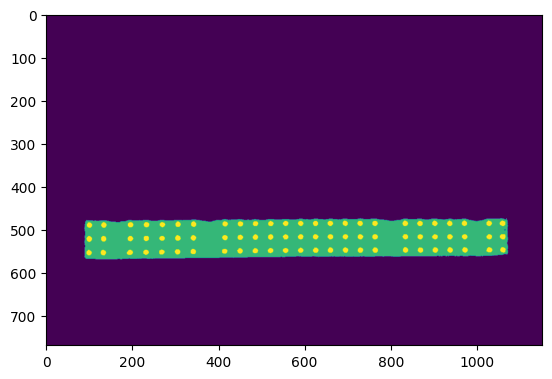

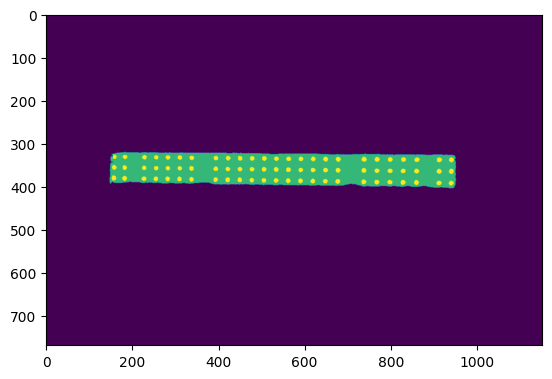

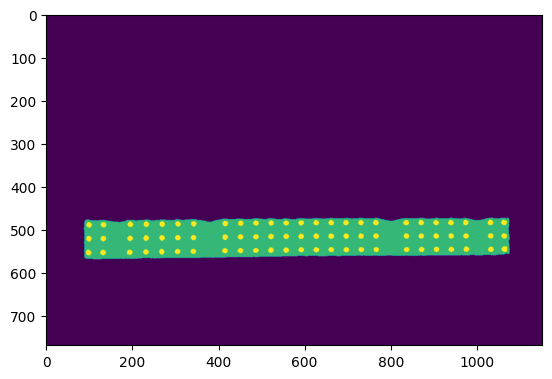

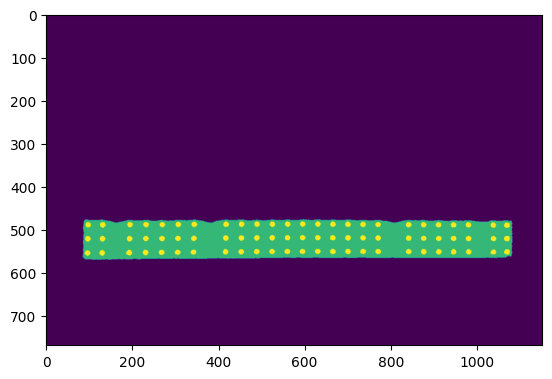

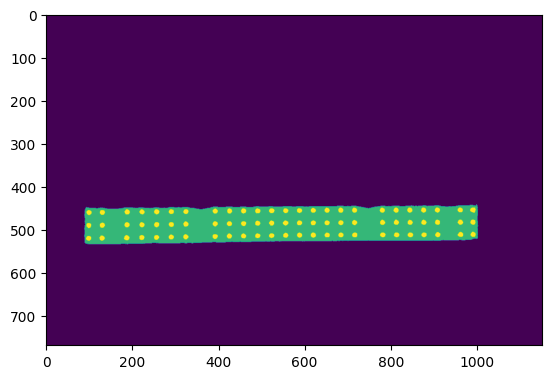

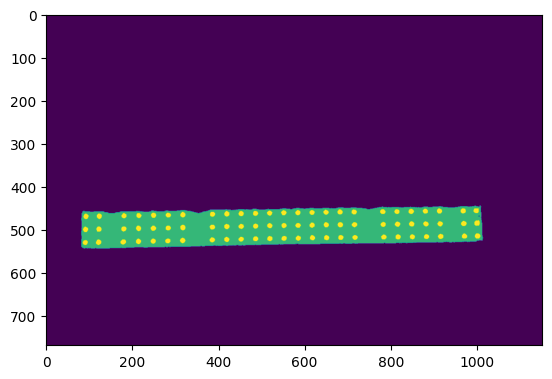

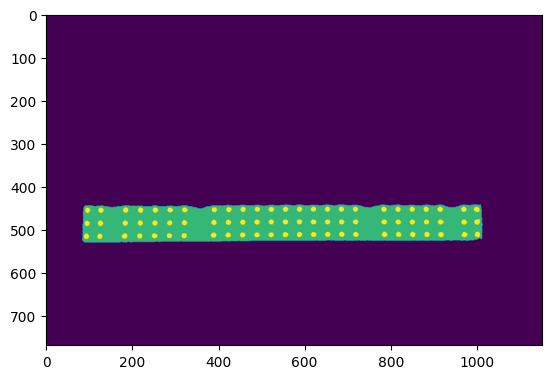

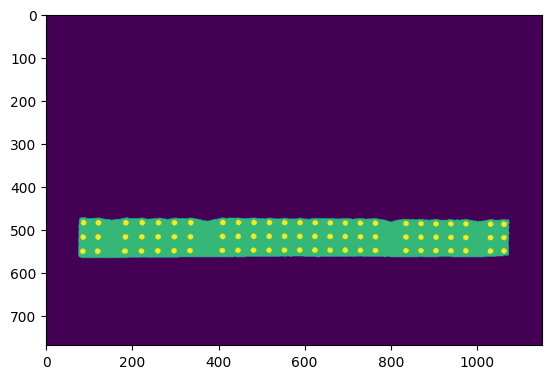

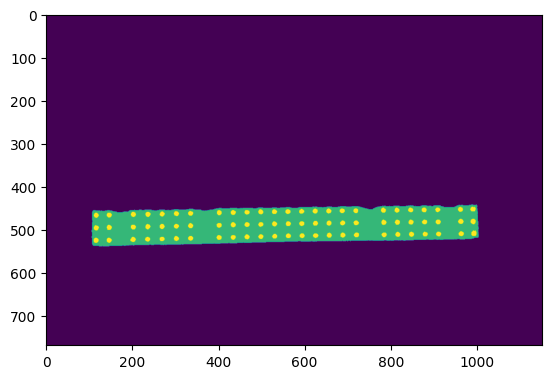

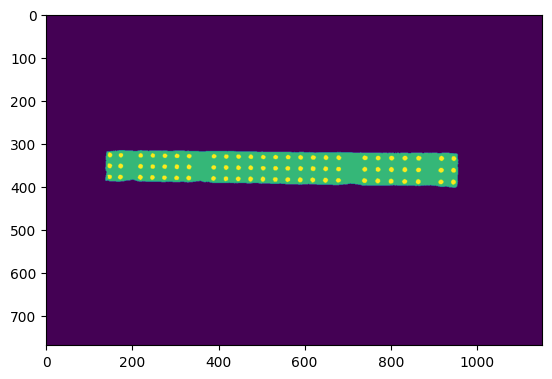

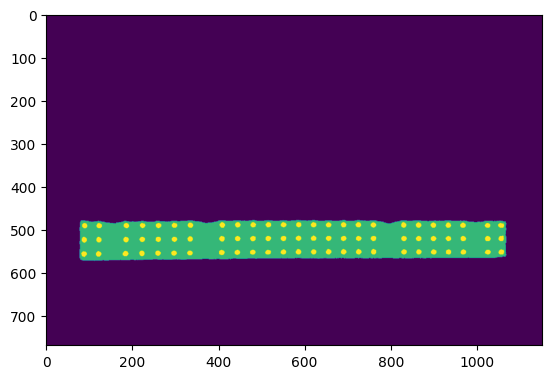

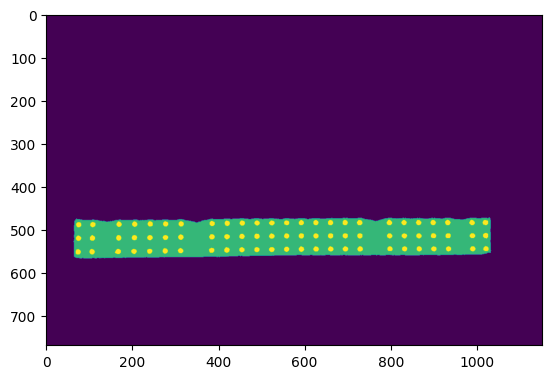

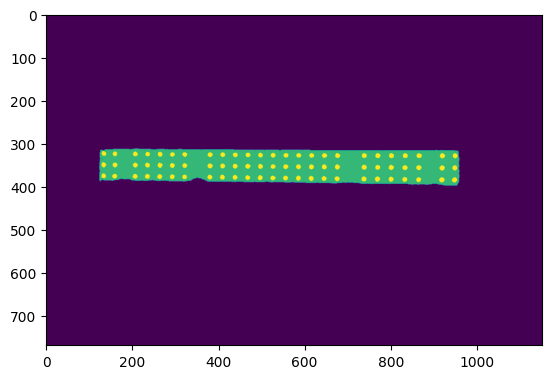

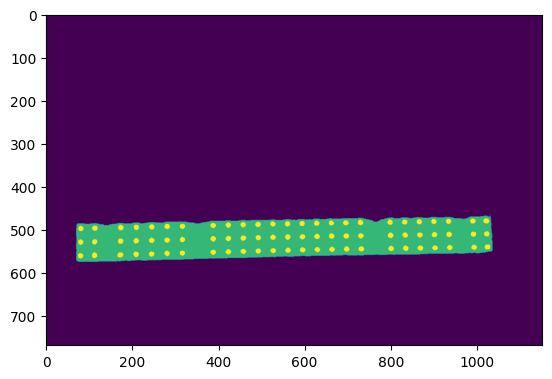

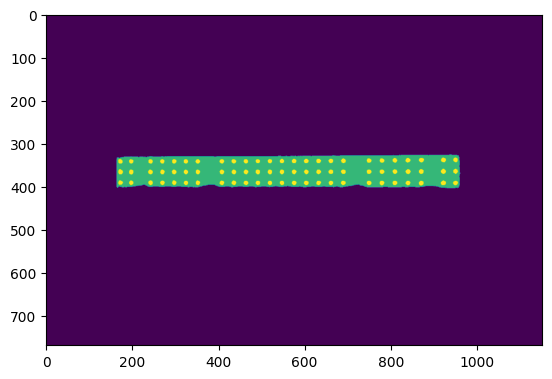

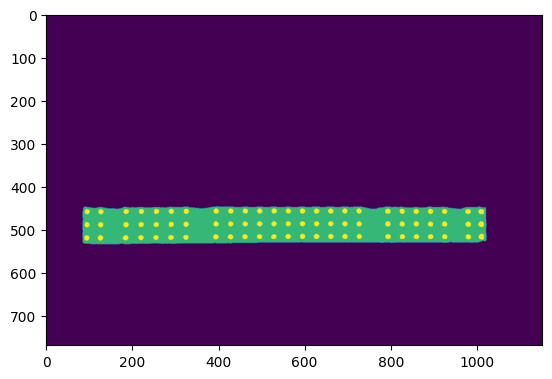

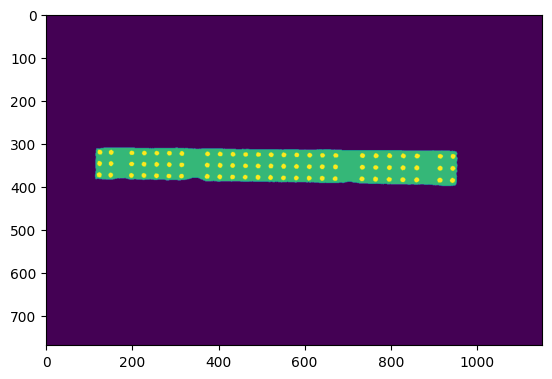

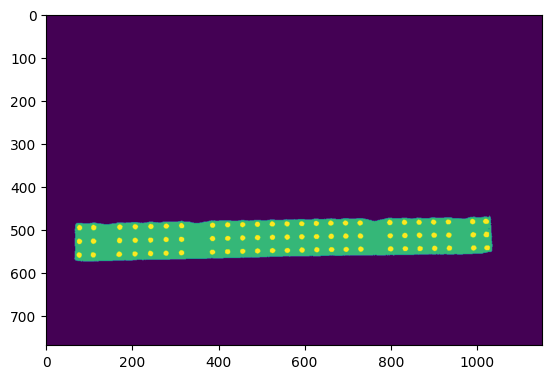

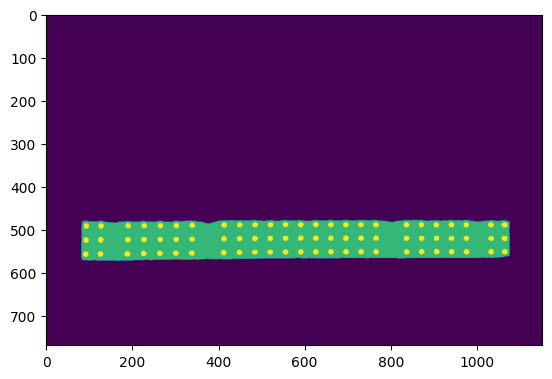

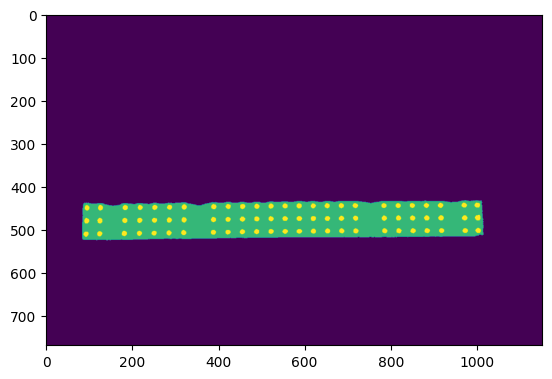

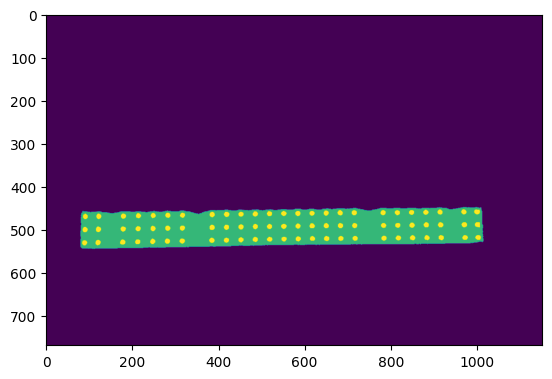

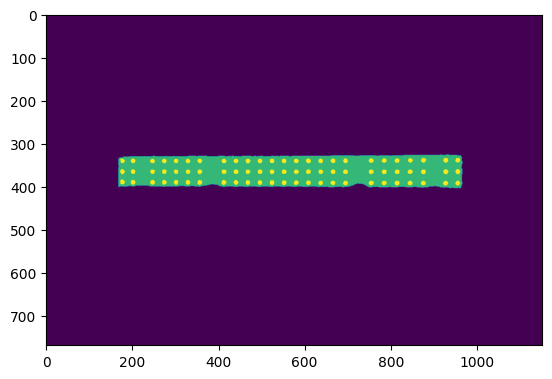

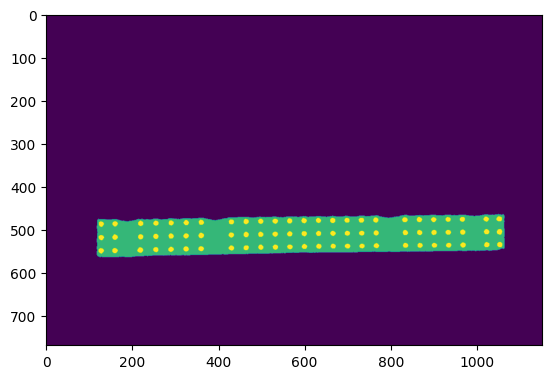

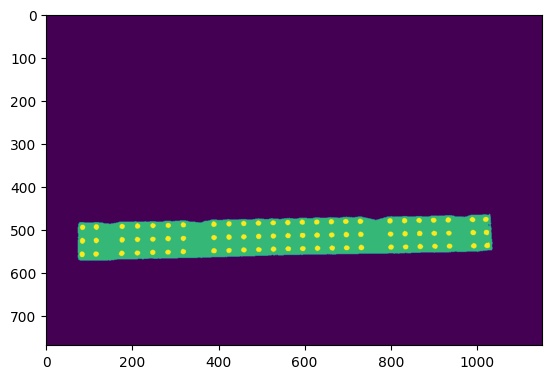

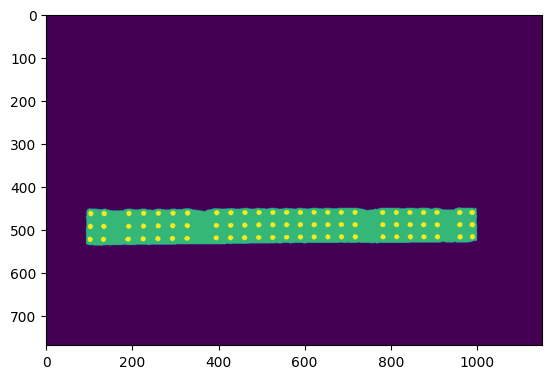

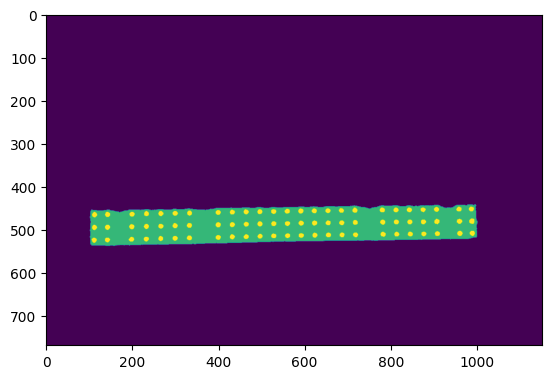

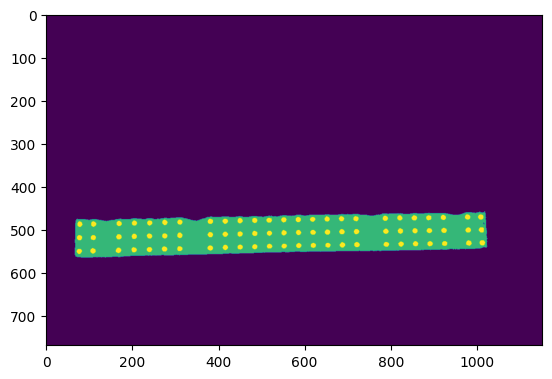

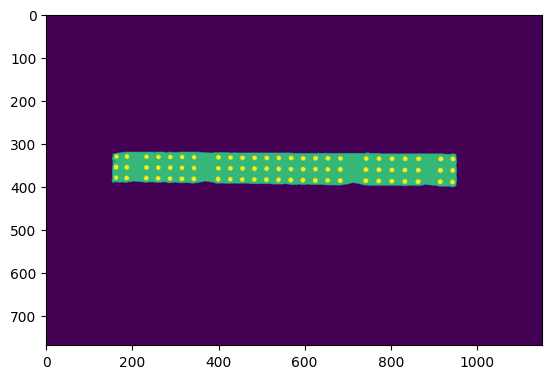

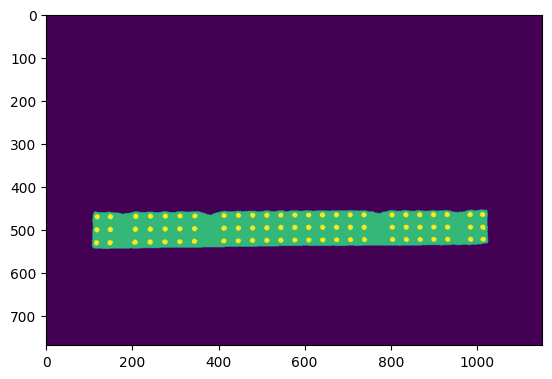

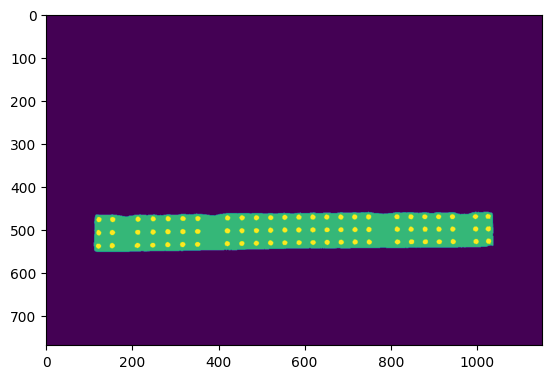

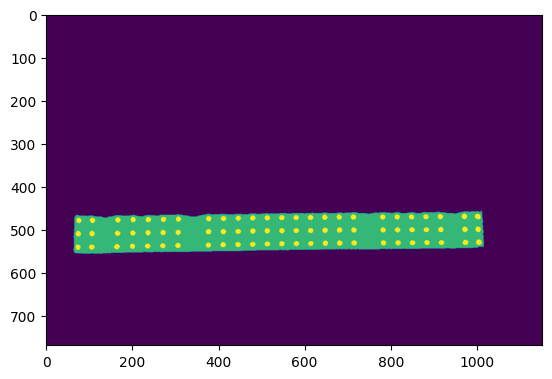

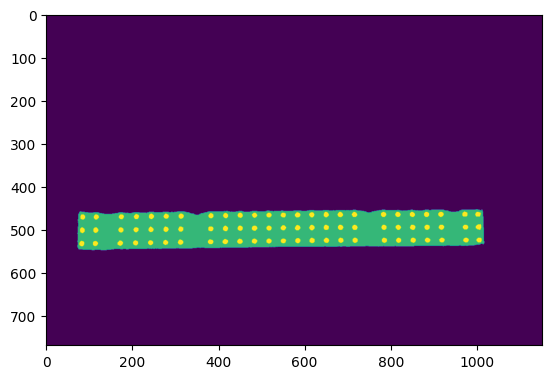

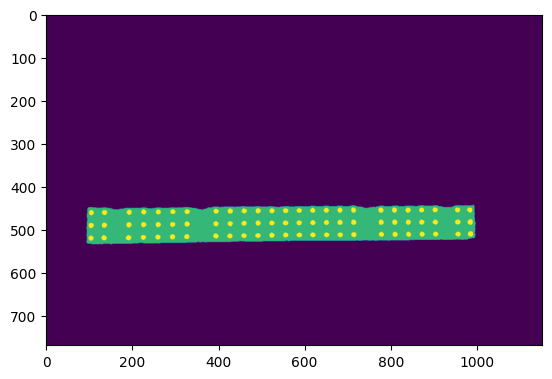

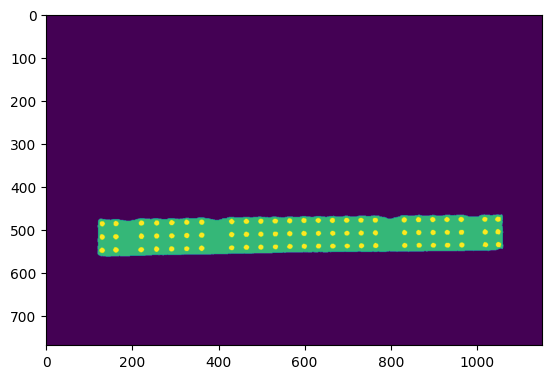

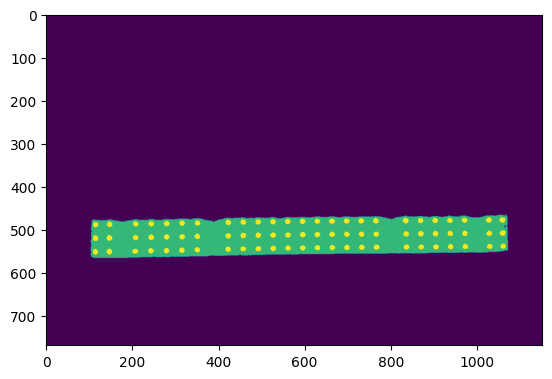

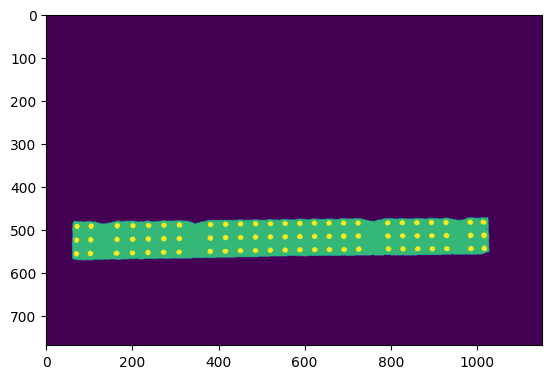

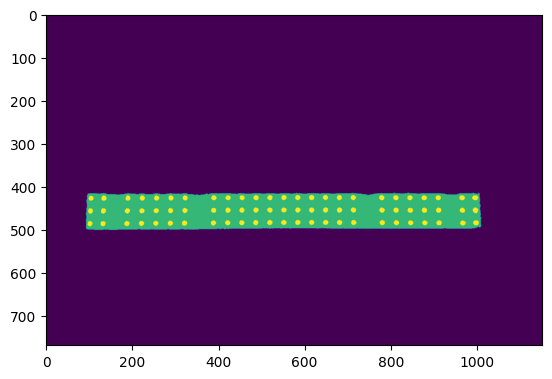

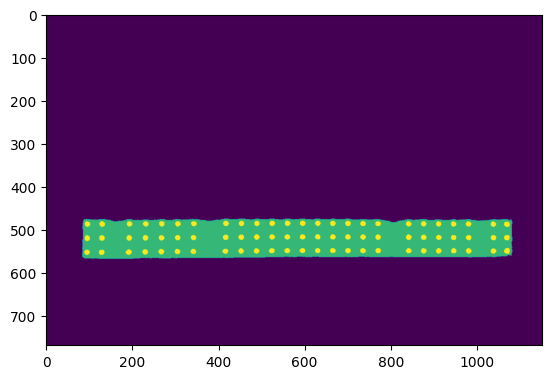

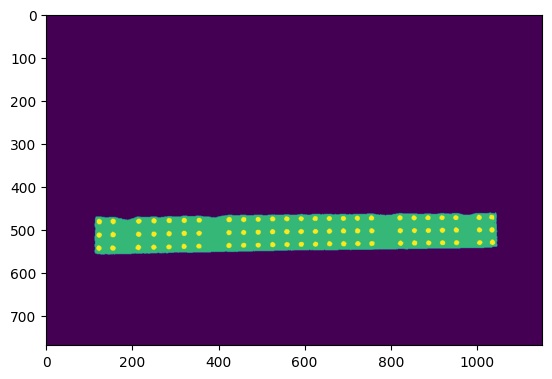

In [16]:
for imgs, folder in zip(imgs_l, path_l):
    if not os.path.exists(SAVE_PATH + folder + "/" + "connection" + "/"):
        os.makedirs(SAVE_PATH + folder + "/" + "connection" + "/")

    if not os.path.exists(SAVE_PATH + folder + "/" + "bolt" + "/"):
        os.makedirs(SAVE_PATH + folder + "/" + "bolt" + "/")

    for img, path in zip(imgs[0], imgs[1]):
        img, _ = transform_image(img)

        masked = predict_image(img).numpy()
        masked = np.float32(masked)

        plt.imshow(masked)
        plt.show()

        _, thresh_1 = cv2.threshold(masked, 1, 128, cv2.THRESH_BINARY)
        _, thresh_2 = cv2.threshold(masked, 2, 255, cv2.THRESH_BINARY)

        cv2.imwrite(SAVE_PATH + folder + "/" + "connection" + '/' + path.split('/')[-1], thresh_1)
        cv2.imwrite(SAVE_PATH + folder + "/" + "bolt" + '/' + path.split('/')[-1], thresh_2)

In [17]:
TRAIN_PATH = "/home/enfycius/Desktop/train_v2/"

In [18]:
import sympy

In [19]:
def appx_best_fit_ngon(mask_cv2, n: int = 4):
    mask_cv2_gray = cv2.cvtColor(mask_cv2, cv2.COLOR_RGB2GRAY)
    
    contours, _ = cv2.findContours(
        mask_cv2_gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
    )

    hull = cv2.convexHull(contours[0])
    hull = np.array(hull).reshape((len(hull), 2))

    hull = [sympy.Point(*pt) for pt in hull]

    while len(hull) > n:
        best_candidate = None

        for edge_idx_1 in range(len(hull)):
            edge_idx_2 = (edge_idx_1 + 1) % len(hull)

            adj_idx_1 = (edge_idx_1 - 1) % len(hull)
            adj_idx_2 = (edge_idx_1 + 2) % len(hull)

            edge_pt_1 = sympy.Point(*hull[edge_idx_1])
            edge_pt_2 = sympy.Point(*hull[edge_idx_2])
            adj_pt_1 = sympy.Point(*hull[adj_idx_1])
            adj_pt_2 = sympy.Point(*hull[adj_idx_2])

            subpoly = sympy.Polygon(adj_pt_1, edge_pt_1, edge_pt_2, adj_pt_2)
            angle1 = subpoly.angles[edge_pt_1]
            angle2 = subpoly.angles[edge_pt_2]

            if sympy.N(angle1 + angle2) <= sympy.pi:
                continue

            adj_edge_1 = sympy.Line(adj_pt_1, edge_pt_1)
            adj_edge_2 = sympy.Line(edge_pt_2, adj_pt_2)
            intersect = adj_edge_1.intersection(adj_edge_2)[0]

            area = sympy.N(sympy.Triangle(edge_pt_1, intersect, edge_pt_2).area)

            if best_candidate and best_candidate[1] < area:
                continue

            better_hull = list(hull)
            better_hull[edge_idx_1] = intersect
            del better_hull[edge_idx_2]
            best_candidate = (better_hull, area)

        if not best_candidate:
            raise ValueError("Could not find the best fit n-gon!")

        hull = best_candidate[0]

    hull = [(int(x), int(y)) for x, y in hull]

    return hull

In [20]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis = 1)

    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

In [21]:
def four_point_transform(image, pts):
	rect = order_points(pts)
	(tl, tr, br, bl) = rect

	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))

	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))

	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")

	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

	return warped

In [22]:
def transform_resize(img):
    img_transforms = A.Compose([A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)])
    aug = img_transforms(image = img)

    img = Image.fromarray(aug['image'])

    return img

In [23]:
def processing(img, connection_label, bolt_label):
    hull = appx_best_fit_ngon(connection_label)
    pts = np.array(hull, dtype = "float32")
    
    ref_img = img
    ref_img = transform_resize(ref_img)
    ref_img = np.array(ref_img)

    ref_bolt_label = bolt_label
    ref_bolt_label = transform_resize(ref_bolt_label)
    ref_bolt_label = np.array(ref_bolt_label)
    
    warped = four_point_transform(ref_img, pts)
    warped_bolt = four_point_transform(ref_bolt_label, pts)

    return [warped, warped_bolt]

In [61]:
radius_mean_sup_lst = []
radius_sup_lst = []

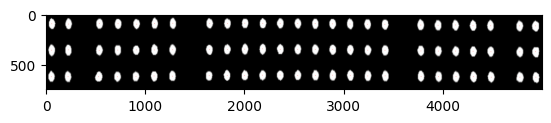

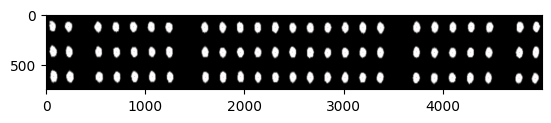

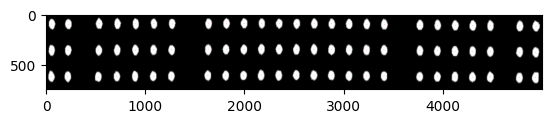

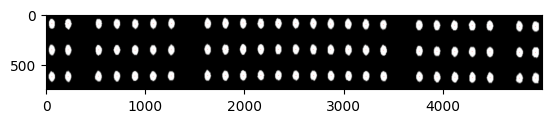

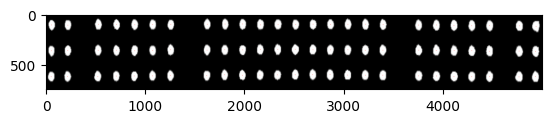

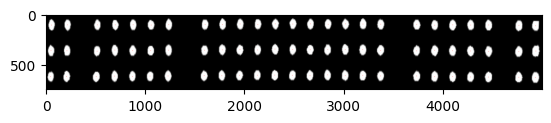

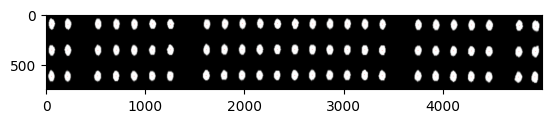

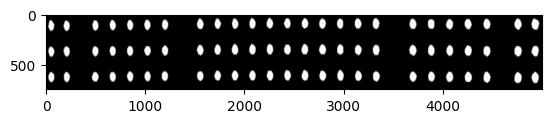

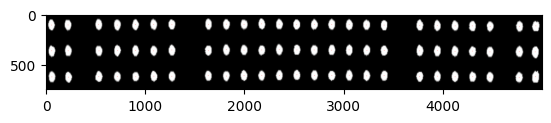

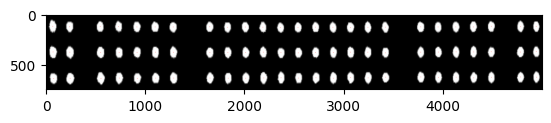

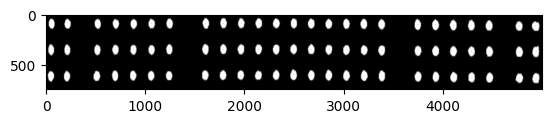

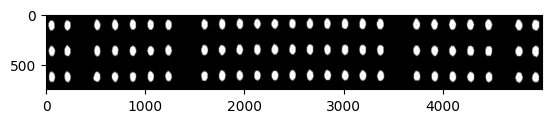

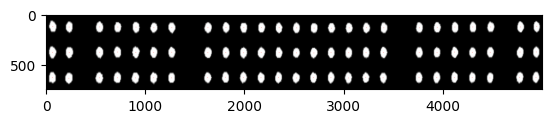

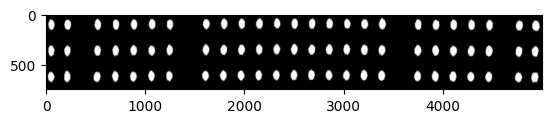

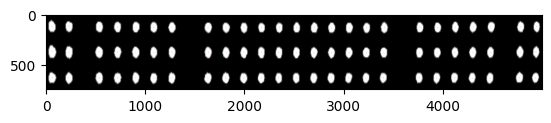

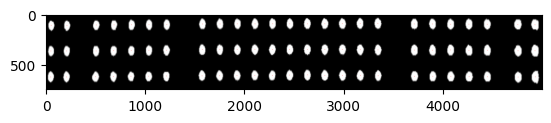

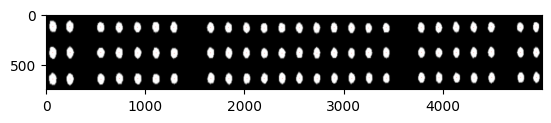

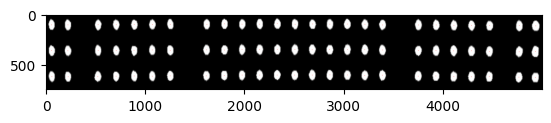

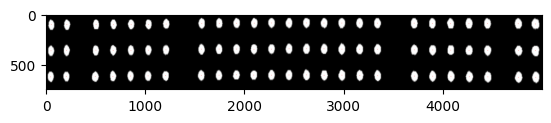

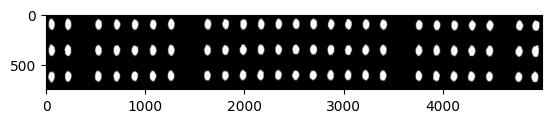

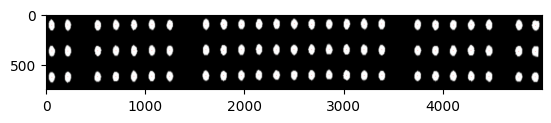

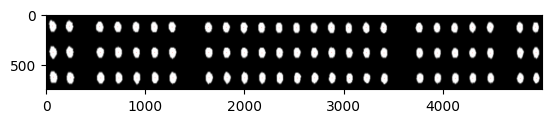

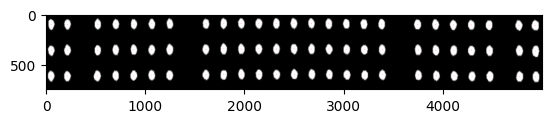

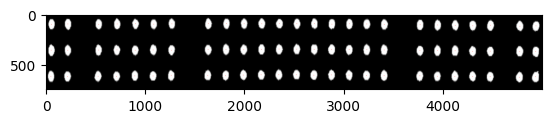

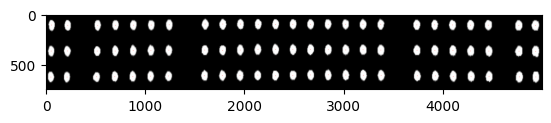

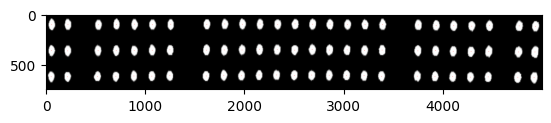

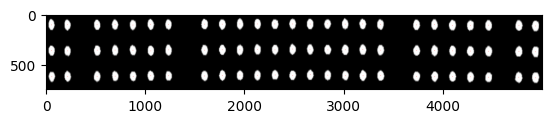

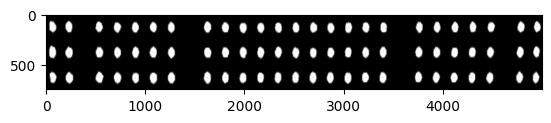

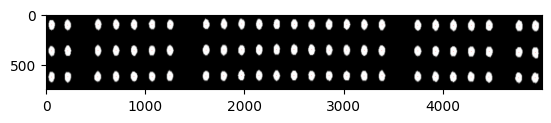

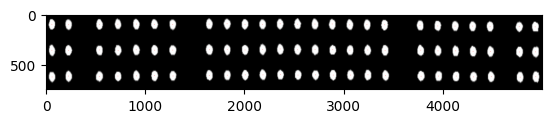

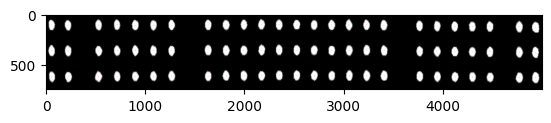

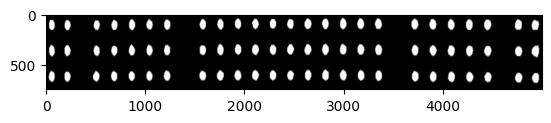

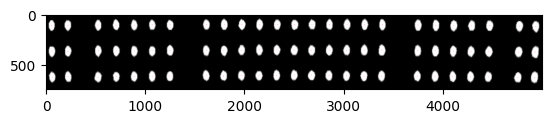

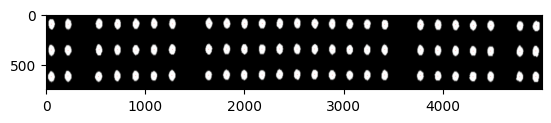

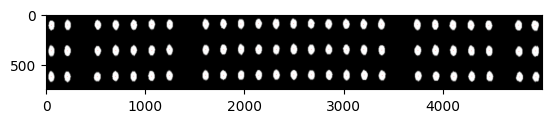

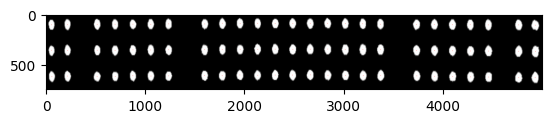

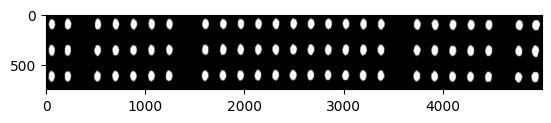

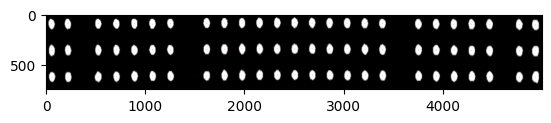

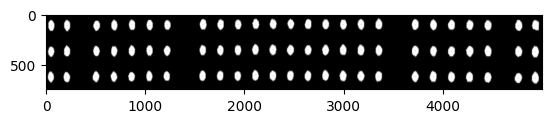

In [62]:
for imgs, folder in zip(imgs_l, path_l):
    _, bolt_img_paths = get_files(SAVE_PATH + folder + "/" + "bolt" + "/")
    _, connection_img_paths = get_files(SAVE_PATH + folder + "/" + "connection" + "/")

    if not os.path.exists(TRAIN_PATH + folder + "/"):
        os.makedirs(TRAIN_PATH + folder + "/")


    for index, (bolt_img_path, connection_img_path) in enumerate(zip(bolt_img_paths, connection_img_paths)):
        img = imgs[0][index]
        bolt_img = cv2.imread(bolt_img_path)
        connection_img = cv2.imread(connection_img_path)
        
        radius_sub_lst = []

        warped, warped_bolt = processing(img, connection_img, bolt_img)

        dst = cv2.resize(warped_bolt, (5000, 750))

        # The below is a modified version.

        dst2 = cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY)

        contours, hierarchy = cv2.findContours(dst2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            M = cv2.moments(cnt)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            center = (int(x), int(y))
            radius = int(radius)
            # radius_sub_lst.append([cX, cY])
            radius_sub_lst.append(radius)

            # cv2.circle(dst, (int(x), int(y)), int(radius), (255,0,0), 2)
            cv2.circle(dst, (cX, cY), 1, (255, 0, 0), 2)

        plt.imshow(dst)
        plt.show()

        # mean of bolt holes
        radius_sub_lst = np.array(radius_sub_lst)
        radius_mean_sup_lst.append(radius_sub_lst.mean())

        # radius_sub_lst = np.array(radius_sub_lst)

        # radius_not_exist_nan = radius_sub_lst[~np.isnan(np.array(radius_sub_lst))]
        
        # radius_sup_lst.append(radius_sub_lst)


        cv2.imwrite(TRAIN_PATH + folder + "/" + imgs[1][index].split('/')[-1], dst)

In [ ]:
# radius_sup_lst

In [52]:
x = []
y = []

In [40]:
len(radius_sup_lst)

102

In [ ]:
for radius_sup in radius_sup_lst:
    x = []
    y = []

    for radius_sub in radius_sup[:]:
        if radius_sub:
            print(radius_sub)
            x.append(radius_sub[0])
            y.append(radius_sub[1])

    plt.figure()
    plt.scatter(x, y)
    plt.show()

In [63]:
len(radius_mean_sup_lst)

39

In [64]:
radius_mean_sup_array = np.array(radius_mean_sup_lst)

In [65]:
radius_mean_not_exist_nan = radius_mean_sup_array[~np.isnan(np.array(radius_mean_sup_lst))]

(array([2., 0., 1., 0., 1., 1., 5., 3., 3., 0., 3., 0., 1., 2., 2., 1., 0.,
        2., 3., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        1., 1., 0., 0., 3.]),
 array([59.77333333, 59.91247863, 60.05162393, 60.19076923, 60.32991453,
        60.46905983, 60.60820513, 60.74735043, 60.88649573, 61.02564103,
        61.16478632, 61.30393162, 61.44307692, 61.58222222, 61.72136752,
        61.86051282, 61.99965812, 62.13880342, 62.27794872, 62.41709402,
        62.55623932, 62.69538462, 62.83452991, 62.97367521, 63.11282051,
        63.25196581, 63.39111111, 63.53025641, 63.66940171, 63.80854701,
        63.94769231, 64.08683761, 64.22598291, 64.36512821, 64.5042735 ,
        64.6434188 , 64.7825641 , 64.9217094 , 65.0608547 , 65.2       ]),
 <BarContainer object of 39 artists>)

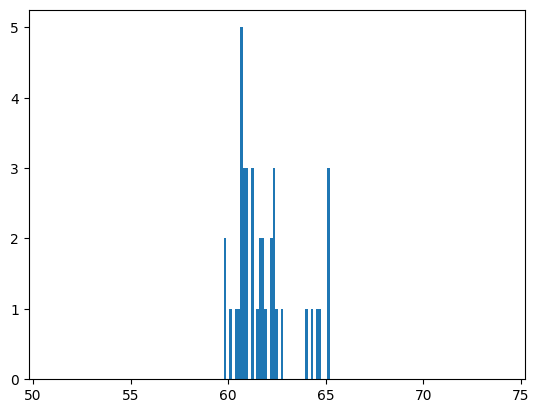

In [66]:
rng = 10

plt.xlim([min(radius_mean_not_exist_nan) - rng, max(radius_mean_not_exist_nan) + rng])
plt.hist(np.array(radius_mean_not_exist_nan), bins = len(radius_mean_not_exist_nan))

In [67]:
np.array(radius_mean_not_exist_nan).mean()

61.8728205128205